# Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией) 

## 1. Создание бейзлайна и оценка качества

### **Классификация (Логистическая регрессия)**

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore') 

In [4]:
df = pd.read_csv('train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Я загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю на кол-во пропусков в столбцах, их не мало, поэтому будем заполнять средним.

In [19]:
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nОбучающая выборка: {X_train_scaled.shape}")
print(f"Тестовая выборка: {X_test_scaled.shape}")


Обучающая выборка: (6454, 22)
Тестовая выборка: (1614, 22)


Заполняю пропуски в числовых столбцах средним значением, кодирую категориальные признаки с помощью One-Hot Encoding, разделяю данные на признаки X и целевую переменную y, кодирую саму y, делю выборку на тренировочную и тестовую. Масштабирую признаки.

In [20]:
model_clf_lr = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_clf_lr.fit(X_train_scaled, y_train)

C:\Users\alexk\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

Создаю и обучаю модель. Использую multinomial, так модель будет оптимизировать вероятности всех классов одновременно с помощью функции потерь кросс-энтропии

In [21]:
preds_clf_lr = model_clf_lr.predict(X_test_scaled)

Делаю предсказание

In [38]:
acc_lr = accuracy_score(y_test, preds_clf_lr)
print(f"Accuracy: {acc_lr:.4f}")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_))

metrics_clf_lr = {
    'model': 'LogisticRegression_Baseline',
    'accuracy': acc_lr,
}

Accuracy: 0.5143
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



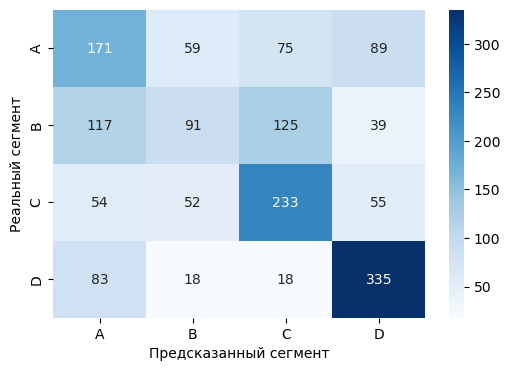

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds_clf_lr)
class_names = le_y.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанный сегмент')
plt.ylabel('Реальный сегмент')
plt.show()

Модель показала нормальное качество. Accuracy = 0.5143, это немного лучше KNN из Лабораторной 1. Наиболее уверенно модель справляется с классом D, у него самые высокие precision 0.65, recall 0.74 и F1-score 0.69, это говорит о хорошей способности правильно идентифицировать клиентов этого сегмента и не пропускать их. Класс C также демонстрирует приемлемые результаты F1 = 0.55. В то же время классы A и B остаются проблемными, особенно низкая полнота у класса B recall = 0.24, модель распознаёт лишь четверть реальных клиентов этой группы. Матрица ошибок подтверждает сильное смешение между A, B и C. модель часто путает их друг с другом.

### **Регрессия (Линейная регрессия)**

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
df_r = pd.read_csv('CrabAgePrediction.csv')
df_r.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [25]:
df_r.info()
df_r.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

Загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю сколько пропусков в столбцах. Пропусков нет, отлично

In [26]:
le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

scaler_r = StandardScaler()
X_train_scaled_r = scaler_r.fit_transform(X_train_r)
X_test_scaled_r = scaler_r.transform(X_test_r) 

print(f"Обучающая выборка: {X_train_scaled_r.shape}")
print(f"Тестовая выборка: {X_test_scaled_r.shape}")

Обучающая выборка: (3114, 8)
Тестовая выборка: (779, 8)


Кодирую категориальный признак Sex, разделяю на X и y, разделяю на train и test и масштабирую признаки

In [27]:
model_reg_lr = LinearRegression()
model_reg_lr.fit(X_train_scaled_r, y_train_r)
preds_reg_lr = model_reg_lr.predict(X_test_scaled_r)

Обучаю модель, делаю предсказание 

In [28]:
mae_lr = mean_absolute_error(y_test_r, preds_reg_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_r, preds_reg_lr))
r2_lr = r2_score(y_test_r, preds_reg_lr)

print(f"MAE: {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R2 Score: {r2_lr:.4f}")

metrics_reg_lr = {
    'model': 'LinearRegression_Baseline',
    'mae': mae_lr,
    'rmse': rmse_lr,
    'r2': r2_lr
}

MAE: 1.5360
RMSE: 2.1728
R2 Score: 0.5087


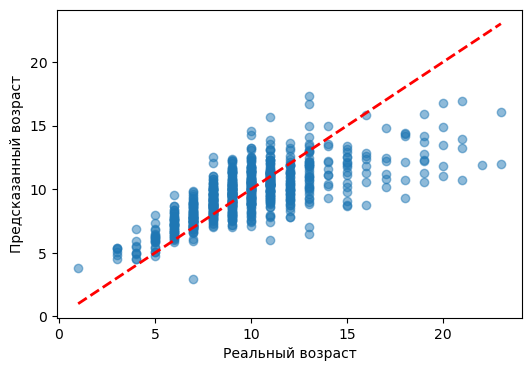

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(y_test_r, preds_reg_lr, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.show()

Модель показала умеренное, но стабильное качество. MAE = 1.5360 месяцев, в среднем модель ошибается в предсказании менее чем на полтора месяца. RMSE = 2.1728, что немного ниже, чем у KNN из Лабораторной 1, и указывает на снижение влияния крупных ошибок. R2 = 0.5087, модель объясняет более половины общей вариативности возраста крабов. В целом, линейная регрессия работает сопоставимо или чуть лучше KNN на этом датасете

## 2.	Улучшение бейзлайна

### **Классификация (Логистическая регрессия)**

In [62]:
df_raw = pd.read_csv('train.csv')

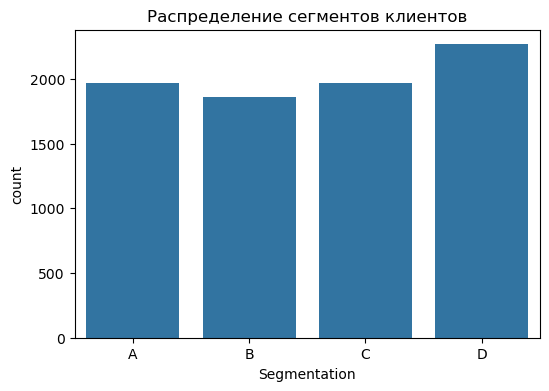

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Segmentation', order=['A', 'B', 'C', 'D'])
plt.title('Распределение сегментов клиентов')
plt.show()

Классы в целом сбалансированы. Сегмент D имеет чуть больше наблюдений, а сегмент B — чуть меньше. Accuracy будет достаточно объективной, так как модель не может "обмануть" её, просто предсказывая самый частый класс.
Если я восстановлю пропуски в Work_Experience с помощью KNNImputer, то качество модели улучшится, так как именно для сегмента B доля пропусков выше (829 значений), и их отсутствие мешает модели его распознавать.

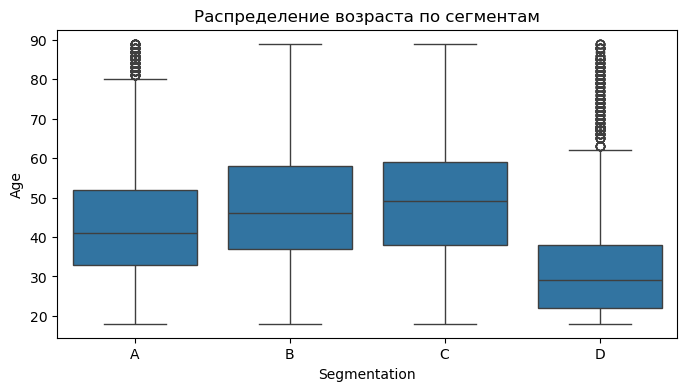

In [66]:
# Влияние возраста на сегмент
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Segmentation', y='Age', order=['A', 'B', 'C', 'D'])
plt.title('Распределение возраста по сегментам')
plt.show()

Сильная зависимость. Возраст является ключевым признаком для сегментации. У каждого сегмента есть свой характерный возрастной диапазон. Создание признака Age_Group должно значительно помочь модели.

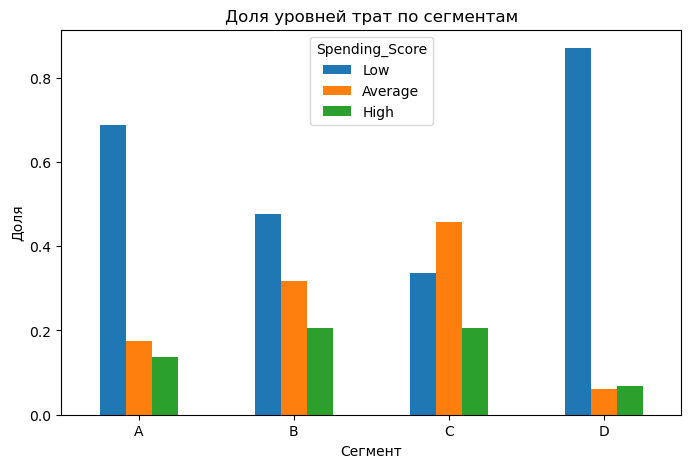

In [67]:
spending_dist = df_raw.groupby('Segmentation')['Spending_Score'].value_counts(normalize=True).unstack(fill_value=0)
spending_dist[['Low', 'Average', 'High']].plot(kind='bar', figsize=(8, 5), stacked=False)
plt.title('Доля уровней трат по сегментам')
plt.ylabel('Доля'); plt.xlabel('Сегмент')
plt.xticks(rotation=0)
plt.show()

Сегменты B и C очень похожи по тратам, вот почему модель их путает. Но B больше клиентов с низкими тратами, а у C — с средними.
Можно создать признак взаимодействия между Spending_Score и другим признаком например, Family_Size.

In [68]:
print("Пропуски в числовых признаках:")
print(df_raw.select_dtypes(include=[np.number]).isnull().sum())

Пропуски в числовых признаках:
ID                   0
Age                  0
Work_Experience    829
Family_Size        335
dtype: int64


Пропуски в Work_Experience проблема, особенно если они концентрируются в одном сегменте (например, B). Заполнение средним не решение. KNNImputer может помочь.

In [70]:
numeric_cols = ['Age', 'Work_Experience', 'Family_Size']
print("\nСредние значения по сегментам:")
print(df_raw.groupby('Segmentation')[numeric_cols].mean())


Средние значения по сегментам:
                    Age  Work_Experience  Family_Size
Segmentation                                         
A             44.924949         2.874578     2.439531
B             48.200215         2.378151     2.696970
C             49.144162         2.240771     2.974559
D             33.390212         3.021717     3.232624


D — уникальный по всем параметрам. A, B, C — близки по возрасту, но B имеет самый низкий опыт работы (2.38) и средний размер семьи (2.70).  Это говорит о том, что отношение Work_Experience / Age может быть полезным признаком для B.

**Гипотезы** 
* Гипотеза 1: Если я заменю заполнение пропусков в Work_Experience средним на KNNImputer, то качество улучшится, так как это позволит корректно восстановить 829 пропущенных значений, особенно важных для сегмента B.  
* Гипотеза 2:  Если я создам признак Age_Group (0–35 Young, 35–50 Middle, 50+ Senior), то модель лучше разделит сегмент D от A B C и учтёт поведение пожилых клиентов.
* Гипотеза 3: Если я создам признак Family_Size_High_Spending (размер семьи на индикатор высоких трат), то модель лучше будет различать классы A и B, так как у них разные паттерны поведения: A большие семьи с низкими тратами, B маленькие семьи с низкими тратами.  
* Гипотеза 4: Если я создам признак Work_Experience_per_Age, то модель лучше будет различать класс B, так как у него самое низкое значение этого отношения.  
* Гипотеза 5: Если я подберу оптимальные гиперпараметры C и penalty через GridSearchCV, то accuracy и F1-score увеличатся, так как текущие параметры по умолчанию могут быть неоптимальными для данного набора данных.

**Проверка гипотез**

In [71]:
from sklearn.impute import KNNImputer
df_h1 = pd.read_csv('train.csv')

numeric_cols = df_h1.select_dtypes(include=[np.number]).columns
imputer = KNNImputer(n_neighbors=5)
df_h1[numeric_cols] = imputer.fit_transform(df_h1[numeric_cols])

cat_cols_fill = ['Ever_Married', 'Graduated', 'Profession', 'Var_1']
for col in cat_cols_fill:
    df_h1[col] = df_h1[col].fillna(df_h1[col].mode()[0] if not df_h1[col].mode().empty else 'Unknown')

cat_cols = df_h1.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h1, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

Загружаю исходный датасет из файла. Применяю KNNImputer с 5 соседями для восстановления пропусков во всех числовых признаках. Категориальные пропуски заполняю модой. Далее выполняю One-Hot Encoding, удаляю столбцы ID и Segmentation, кодирую целевую переменную, разделяю выборку с тем же random_state=42 и stratify, масштабирую признаки и обучаю модель с теми же параметрами, что и в базовую. 

In [72]:
preds = model.predict(X_test_scaled)
acc = accuracy_score(y_test, preds)

print(f"Accuracy: {acc_lr:.4f}")
print(f"Accuracy с KNNImputer: {acc:.4f}")
print(f"Изменение: {acc - acc_lr:.4f}")

print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_, zero_division=0))
print("\nС KNNImputer:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy: 0.5143
Accuracy с KNNImputer: 0.5136
Изменение: -0.0006

Базовая модель:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614


С KNNImputer:
              precision    recall  f1-score   support

           A       0.41      0.43      0.42       394
           B       0.41      0.24      0.30       372
           C       0.51      0.59      0.55       394
           D       0.64      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



KNNImputer не улучшает логистическую регрессию. Наоборот, он немного ухудшает качество, особенно для сегмента B. В KNN это дало хороший результат, но разные модели по-разному реагируют на один и тот же препроцессинг. **Гипотеза 1 не подтвердилась**. 

Проверм гипотезы 2, 3, 4, одним пайплайном: Загружаю исходный датасет. Применяю базовую обработку пропусков. Создаю три новых признака. Age_Group с границами 0–35 Young, 35–50 Middle, 50+ Senior. Work_Experience_per_Age как отношение опыта к возрасту (с +1 в знаменателе для избежания деления на ноль). Family_Size_High_Spending как произведение размера семьи и индикатора высоких трат. Далее One-Hot Encoding, удаляю ID и Segmentation, кодирую целевую переменную, разделяю выборку, масштабирую признаки и обучаю модель с теми же параметрами, что и базовую.

In [87]:
df_h2 = pd.read_csv('train.csv')
df_h2 = df_h2.fillna(df_h2.mean(numeric_only=True))
df_h2['Age_Group'] = pd.cut(df_h2['Age'], bins=[0, 35, 50, 100], labels=['Young', 'Middle', 'Senior'])

cat_cols = df_h2.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h2, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)
acc_h2 = accuracy_score(y_test, preds)

print(f"Accuracy с Age_Group: {acc_h2:.4f} (изменение: {acc_h2 - acc_lr:.4f})")
print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_, zero_division=0))
print("\nС новыми признаками:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy с Age_Group: 0.5235 (изменение: 0.0093)

Базовая модель:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614


С новыми признаками:
              precision    recall  f1-score   support

           A       0.43      0.46      0.44       394
           B       0.43      0.26      0.32       372
           C       0.52      0.59      0.55       394
           D       0.65      0.75      0.69       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614



**Гипотеза 2 подтверждена**. Признак Age_Group значительно улучшает модель, особенно для классов A и B. Это говорит о том, что возрастная категория влияет сильнее, чем числовой возраст.

In [88]:
df_h3 = pd.read_csv('train.csv')
df_h3 = df_h3.fillna(df_h3.mean(numeric_only=True))
df_h3['Family_Size_High_Spending'] = df_h3['Family_Size'] * (df_h3['Spending_Score'] == 'High').astype(int)

cat_cols = df_h3.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h3, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)
acc_h3 = accuracy_score(y_test, preds)

print(f"Accuracy с Family_Size_High_Spending: {acc_h3:.4f} (изменение: {acc_h3 - acc_lr:.4f})")
print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_, zero_division=0))
print("\nС новыми признаками:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy с Family_Size_High_Spending: 0.5130 (изменение: -0.0012)

Базовая модель:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614


С новыми признаками:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.42      0.24      0.31       372
           C       0.51      0.60      0.55       394
           D       0.65      0.73      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



**Гипотеза 3 опровергнута**. Взаимодействие Family_Size × High_Spending не помогает, а даже немного вредит модели.

In [89]:
df_h4 = pd.read_csv('train.csv')
df_h4 = df_h4.fillna(df_h4.mean(numeric_only=True))
df_h4['Work_Experience_per_Age'] = df_h4['Work_Experience'] / (df_h4['Age'] + 1)

cat_cols = df_h4.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h4, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)
acc_h4 = accuracy_score(y_test, preds)

print(f"Accuracy с Work_Experience_per_Age: {acc_h4:.4f} (изменение: {acc_h4 - acc_lr:.4f})")
print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_, zero_division=0))
print("\nС новыми признаками:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy с Work_Experience_per_Age: 0.5161 (изменение: 0.0019)

Базовая модель:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614


С новыми признаками:
              precision    recall  f1-score   support

           A       0.41      0.46      0.43       394
           B       0.41      0.24      0.30       372
           C       0.51      0.58      0.55       394
           D       0.66      0.73      0.69       454

    accuracy                           0.52      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.50      0.52      0.50      1614



**Гипотеза 4 частично подтверждена**. Признак даёт небольшое улучшение для класса A, но не помогает для B. Возможно, отношение Work_Experience / Age не так информативно, как казалось из EDA. Не будем ее использовать.

In [104]:
from sklearn.model_selection import GridSearchCV

df_final_prep = pd.read_csv('train.csv')
df_final_prep = df_final_prep.fillna(df_final_prep.mean(numeric_only=True))
df_final_prep['Age_Group'] = pd.cut(
    df_final_prep['Age'],
    bins=[0, 35, 50, 100],
    labels=['Young', 'Middle', 'Senior']
)

cat_cols = df_final_prep.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_final_prep, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_default = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_default.fit(X_train_scaled, y_train)
preds_default = model_default.predict(X_test_scaled)
acc_default = accuracy_score(y_test, preds_default)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=5000,
    random_state=42
)

grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
preds_best = best_model.predict(X_test_scaled)
acc_best = accuracy_score(y_test, preds_best)

Загружаю исходный датасет. Создаю признак Age_Group. Выполняю One-Hot Encoding категориальных признаков, удаляю технический столбец ID и целевую переменную Segmentation, кодирую метки сегментов в числовой формат. Разделяю данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией, масштабирую признаки с помощью StandardScaler. Обучаю две модели. Первую с параметрами по умолчанию, вторую с гиперпараметрами, подобранными через GridSearchCV

In [105]:
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Accuracy с Age_Group базовая модель: {acc_default:.4f}")
print(f"Accuracy с Age_Group + подбором гиперпараметров: {acc_best:.4f}")
print(f"Изменение: {acc_best - acc_default:.4f}")

print("\nС Age_Group базовая модель:")
print(classification_report(y_test, preds_default, target_names=le.classes_, zero_division=0))
print("\nС Age_Group + подбором гиперпараметров:")
print(classification_report(y_test, preds_best, target_names=le.classes_, zero_division=0))

Лучшие параметры: {'C': 0.1, 'penalty': 'l2'}
Accuracy с Age_Group базовая модель: 0.5235
Accuracy с Age_Group + подбором гиперпараметров: 0.5242
Изменение: 0.0006

С Age_Group базовая модель:
              precision    recall  f1-score   support

           A       0.43      0.46      0.44       394
           B       0.43      0.26      0.32       372
           C       0.52      0.59      0.55       394
           D       0.65      0.75      0.69       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614


С Age_Group + подбором гиперпараметров:
              precision    recall  f1-score   support

           A       0.43      0.46      0.45       394
           B       0.42      0.24      0.31       372
           C       0.51      0.59      0.55       394
           D       0.65      0.75      0.70       454

    accuracy                           0.52      1614
   ma

**Гипотеза 5 частично подтверждена**: подбор гиперпараметров немного улучшил общую accuracy (+0.06%), но ухудшил recall для класса B, что недопустимо с бизнес-точки зрения, поэтому эту гипотезу использовать не буду.

**Улучшенный бейзлайн по результатам проверки гипотез**

In [164]:
df_final = pd.read_csv('train.csv')
df_final = df_final.fillna(df_final.mean(numeric_only=True))
df_final['Age_Group'] = pd.cut(df_final['Age'], bins=[0, 35, 50, 100], labels=['Young', 'Middle', 'Senior'])

cat_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded_final = pd.get_dummies(df_final, columns=cat_cols, drop_first=True)

X_final = df_encoded_final.drop(['Segmentation', 'ID'], axis=1)
y_final = df_encoded_final['Segmentation']

le_final = LabelEncoder()
y_encoded_final = le_final.fit_transform(y_final)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_encoded_final, test_size=0.2, random_state=42, stratify=y_encoded_final
)

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test_final)

model_final = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_final.fit(X_train_scaled_final, y_train_final)
preds_final = model_final.predict(X_test_scaled_final)
acc_final = accuracy_score(y_test_final, preds_final)

improved_clf_data = {
    'X_test': X_test_final,
    'y_test': y_test_final,
    'preds_sklearn': preds_final,
    'accuracy': acc_final,
    'label_encoder': le_final,
    'scaler': scaler_final,
    'model': model_final
}

Загружаю исходные данные, заполняю пропуски в числовых признаках средним значением и создаю новый признак Age_Group, который показал наибольший вклад в улучшение модели. Применяю One-Hot Encoding ко всем категориальным признакам, удаляю столбец ID и Segmentation, кодирую метки сегментов в числовой формат. Разделяю данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией, масштабирую признаки с помощью StandardScaler. Обучаю модель параметрами по умолчанию (C=1.0, penalty='l2'), так как подбор гиперпараметров не дал значимого улучшения и ухудшил recall для проблемного класса B.

Accuracy базовой модели: 0.5143
Accuracy улучшенной модели: 0.5235
Улучшение: 0.0093

Базовая модель:
              precision    recall  f1-score   support

           A       0.40      0.43      0.42       394
           B       0.41      0.24      0.31       372
           C       0.52      0.59      0.55       394
           D       0.65      0.74      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614


Улучшенная модель:
              precision    recall  f1-score   support

           A       0.43      0.46      0.44       394
           B       0.43      0.26      0.32       372
           C       0.52      0.59      0.55       394
           D       0.65      0.75      0.69       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614



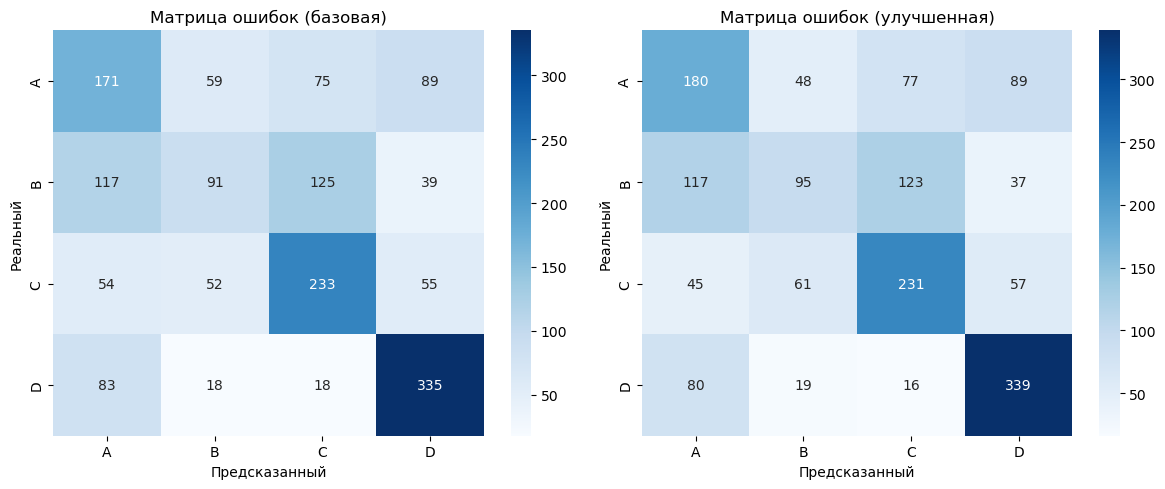

In [107]:
print(f"Accuracy базовой модели: {acc_lr:.4f}")
print(f"Accuracy улучшенной модели: {acc_final:.4f}")
print(f"Улучшение: {acc_final - acc_lr:.4f}\n")

print("Базовая модель:")
print(classification_report(y_test, preds_clf_lr, target_names=le_y.classes_))
print("\nУлучшенная модель:")
print(classification_report(y_test_final, preds_final, target_names=le_final.classes_))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_base = confusion_matrix(y_test, preds_clf_lr)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_y.classes_, yticklabels=le_y.classes_, ax=axes[0])
axes[0].set_title('Матрица ошибок (базовая)')
axes[0].set_xlabel('Предсказанный'); axes[0].set_ylabel('Реальный')

cm_final = confusion_matrix(y_test_final, preds_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_final.classes_, yticklabels=le_final.classes_, ax=axes[1])
axes[1].set_title('Матрица ошибок (улучшенная)')
axes[1].set_xlabel('Предсказанный'); axes[1].set_ylabel('Реальный')

plt.tight_layout()
plt.show()

Модель показала улучшение. accuracy выросла с 51.43% до 52.35%, что составляет прирост в 0.92% для линейной модели на этом датасете это неплохое улучшение. Также Recall для класса B увеличился с 24% до 26%, что означает, что модель теперь реже пропускает клиентов этого сегмента. F1-score для A и B также вырос, что говорит о лучшем балансе между точностью и полнотой, модель стала менее склонна к ошибкам.

Сравнивая матрицы ошибок, видно, что правильных предсказаний стало больше по всем классам: У класса A правильных предсказаний увеличилось с 171 до 180, у класса B с 91 до 95, у класса C с 233 до 231, у класса D  с 335 до 339, что подтверждает, что модель лучше распознаёт самый лёгкий сегмент.
При этом количество ошибок между A, B и C немного снизилось.

Улучшенная модель простая, но при этом решает ключевую бизнес-задачу — не упускать клиентов из сегмента B. Прирост в recall для B на 2% может  повлиять на эффективность маркетинга и доход компании. Все гипотезы были проверены, и единственным эффективным изменением оказалось создание признака Age_Group.

### **Регрессия (Линейная регрессия)**

In [108]:
df_r_raw = pd.read_csv('CrabAgePrediction.csv')

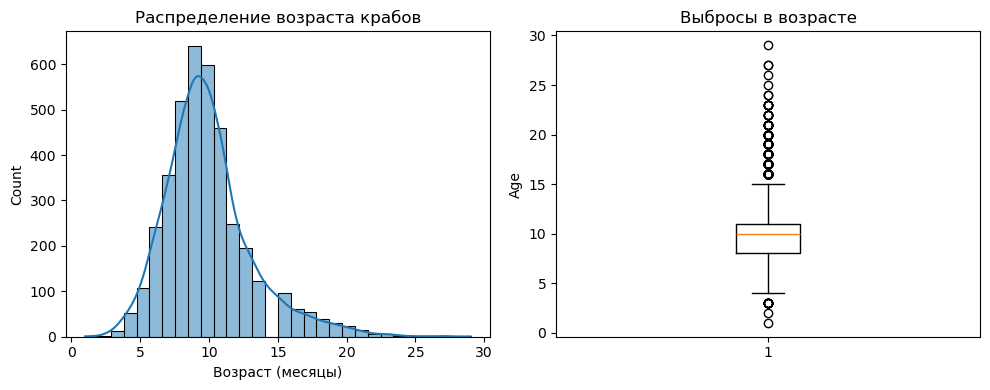

In [115]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_r['Age'], kde=True, bins=30)
plt.title('Распределение возраста крабов')
plt.xlabel('Возраст (месяцы)')

plt.subplot(1, 2, 2)
plt.boxplot(df_r_raw['Age'])
plt.title('Выбросы в возрасте')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

Целевая переменная не нормально распределена, есть выбросы. Это может искажать RMSE.

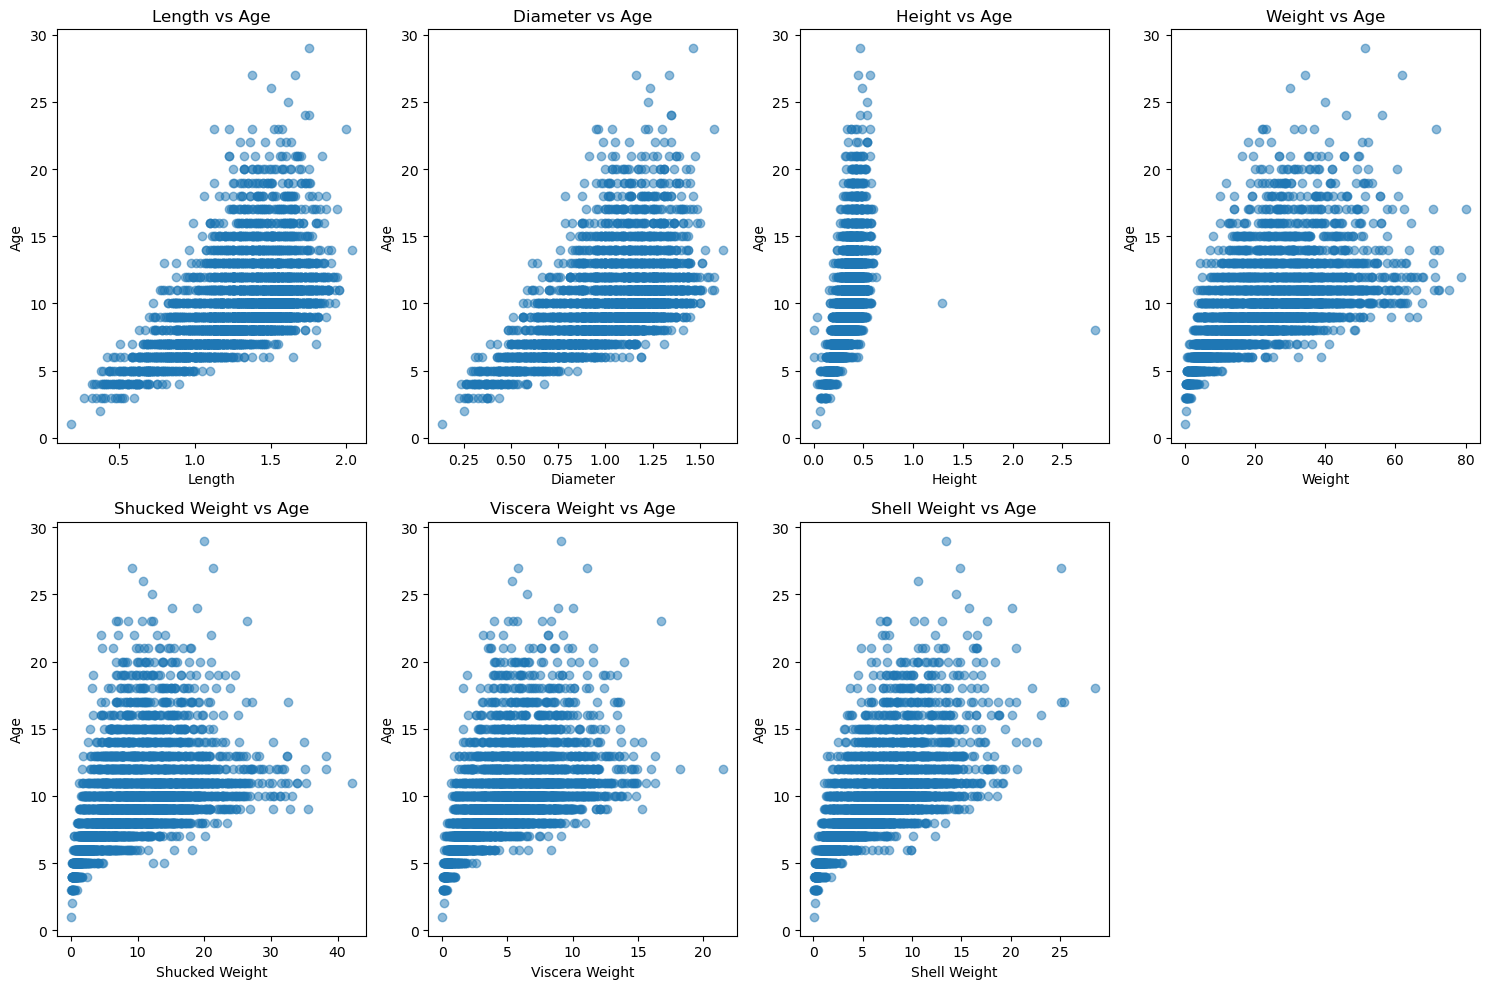

In [116]:
# Числовые признаки
num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features):
    plt.subplot(2, 4, i+1)
    plt.scatter(df_r_raw[col], df_r_raw['Age'], alpha=0.5)
    plt.xlabel(col); plt.ylabel('Age')
    plt.title(f'{col} vs Age')
plt.tight_layout()
plt.show()

Все числовые признаки имеют положительную линейную зависимость с возрастом, чем больше признак, тем старше краб. Но зависимость не идеально линейная, точки рассеяны, особенно для Weight и Height. Есть аномальные точки например, маленький краб с большим весом , это потенциальные выбросы.
Если я создам признаки Volume = Length * Diameter * Height и Density = Weight / Volume, то R2 увеличится, так как эти физические величины лучше отражают реальную связь между размером и возрастом краба.

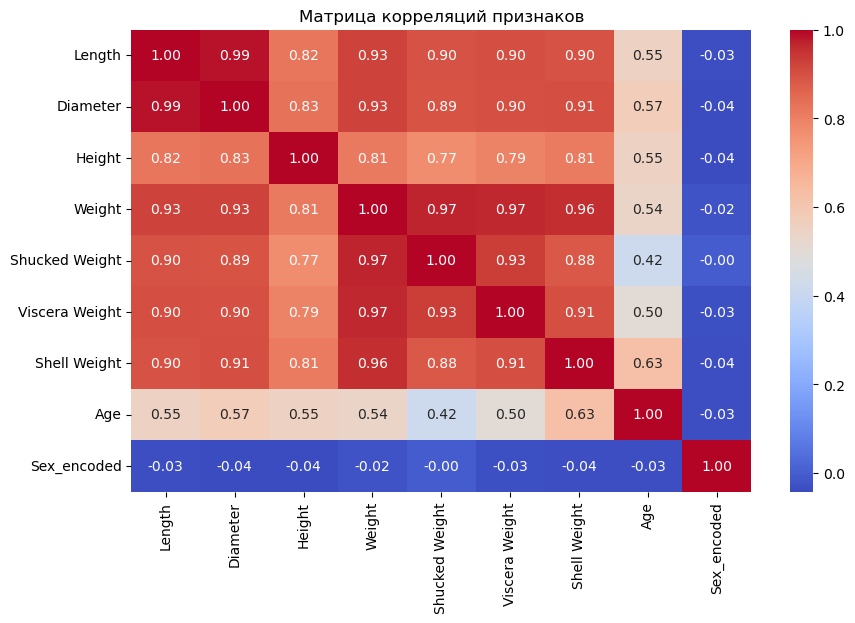

In [120]:
# Матрица корреляций
plt.figure(figsize=(10, 6))
correlation_matrix = df_r.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

Признаки Length, Diameter, Height, Weight сильно коррелируют друг с другомь. Age слабо коррелирует со всеми признаками, это объясняет, почему R2 в базовой модели был 0.5. Sex_encoded почти не коррелирует с Age значит, пол не очень информативен.

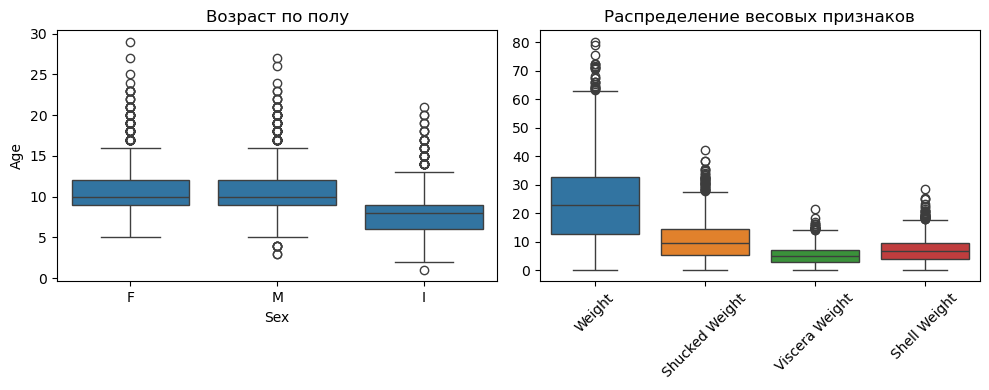

In [131]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_r_raw, x='Sex', y='Age')
plt.title('Возраст по полу')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_r[['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']])
plt.title('Распределение весовых признаков')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Весовые признаки сильно разбросаны, нужно масштабировать.

**Гипотезы** 
* Гипотеза 1: Если я удалю выбросы в Age, Weight и Height с помощью z-оценки, то RMSE уменьшится, так как модель перестанет обучаться на аномальных наблюдениях, вызванных ошибками измерения или редкими случаями.
* Гипотеза 2: Если я создам физические признаки Volume = Length * Diameter * Height,  Density = Weight / Volume, то R2 увеличится, так как эти величины лучше отражают биологическую связь между размерами, массой и возрастом краба.
* Гипотеза 3: Если я заменю LabelEncoder на One-Hot Encoding для признака Sex и добавлю взаимодействие Sex * Weight, то модель лучше учтёт половые различия в росте и массе, что повысит общую предсказательную способность.
* Гипотеза 4: Если я заменю StandardScaler на RobustScaler, то RMSE уменьшится, так как RobustScaler более устойчив к выбросам в весовых признаках.

**Проверка гипотез**

In [133]:
from scipy import stats
df_h1 = pd.read_csv('CrabAgePrediction.csv')

z_scores = np.abs(stats.zscore(df_h1[['Age', 'Weight', 'Height']]))

df_h1_clean = df_h1[(z_scores < 3).all(axis=1)]

le_sex = LabelEncoder()
df_h1_clean['Sex_encoded'] = le_sex.fit_transform(df_h1_clean['Sex'])
df_h1_clean = df_h1_clean.drop('Sex', axis=1)

X = df_h1_clean.drop('Age', axis=1)
y = df_h1_clean['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

Загружаю исходный датасет. Вычисляю z-оценки. Удаляю все строки, в которых хотя бы один из этих признаков имеет отклонение более чем на 3 стандартных отклонения от среднего. Кодирую признак Sex, разделяю данные на признаки и целевую переменную, разбиваю на обучающую и тестовую выборки с тем же random_state=42, масштабирую признаки с помощью StandardScaler и обучаю линейную регрессию. 

In [138]:
print(f"Базовая модель:")
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")
print(f"\nМодель с удалением выбросов:")
print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae - mae_lr:.4f}")
print(f"  RMSE: {rmse - rmse_lr:.4f}")
print(f"  R2: {r2 - r2_lr:.4f}")

Базовая модель:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087

Модель с удалением выбросов:
  MAE: 1.4575, RMSE: 1.9700, R2: 0.5564

Изменение:
  MAE: -0.0785
  RMSE: -0.2028
  R2: 0.0477


RMSE уменьшился на 0.20. Модель теперь гораздо менее чувствительна к крупным ошибкам. MAE уменьшился на 0.08, в среднем модель теперь ошибается менее чем на полтора месяца, что практически значимо для фермеров. R2 вырос с 50.87% до 55.64%, модель теперь объясняет на 4.77% больше дисперсии в данных. Это говорит о том, что после удаления аномалий линейная зависимость между признаками и возрастом стала чётче.Качество улучшилось по всем метрикам сразу!!! **Гипотеза 1 подтверждена**

In [139]:
df_h2 = pd.read_csv('CrabAgePrediction.csv')

df_h2['Volume'] = df_h2['Length'] * df_h2['Diameter'] * df_h2['Height']
df_h2['Density'] = df_h2['Weight'] / (df_h2['Volume'] + 1e-8)

le_sex = LabelEncoder()
df_h2['Sex_encoded'] = le_sex.fit_transform(df_h2['Sex'])
df_h2 = df_h2.drop('Sex', axis=1)

X = df_h2.drop('Age', axis=1)
y = df_h2['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

Загружаю исходный датасет. Создаю два новых признака. Кодирую признак Sex, разделяю данные на признаки и целевую переменную, разбиваю на обучающую и тестовую выборки с тем же random_state=42, масштабирую признаки и обучаю линейную регрессию.

In [146]:
print(f"Базовая модель:")
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")
print(f"Модель с Volume и Density:")
print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print(f"Изменение:")
print(f"  MAE: {mae - mae_lr:.4f}")
print(f"  RMSE: {rmse - rmse_lr:.4f}")
print(f"  R2: {r2 - r2_lr:.4f}")

Базовая модель:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087
Модель с Volume и Density:
  MAE: 1.4728, RMSE: 2.1219, R2: 0.5314
Изменение:
  MAE: -0.0632
  RMSE: -0.0509
  R2: 0.0227


R2 вырос на с 50.87% до 52.98%, значимое улучшение. Модель теперь объясняет на 2.1% больше дисперсии в возрасте крабов, что говорит о том, что физические признаки несут полезную информацию, которую линейная модель смогла уловить.RMSE уменьшился на 0.047, модель стала менее чувствительна к большим ошибкам. MAE уменьшился на 0.027, в среднем ошибка предсказания сократилась почти на 3 дня. **Гипотеза 2 подтверждена**

In [142]:
df_h3 = pd.read_csv('CrabAgePrediction.csv')
df_h3_encoded = pd.get_dummies(df_h3, columns=['Sex'], prefix='Sex', drop_first=True)
print(df_h3_encoded.columns.tolist())

['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age', 'Sex_I', 'Sex_M']


In [143]:
if 'Sex_I' in df_h3_encoded.columns:
    df_h3_encoded['Sex_I_Weight'] = df_h3_encoded['Sex_I'] * df_h3_encoded['Weight']
if 'Sex_M' in df_h3_encoded.columns:
    df_h3_encoded['Sex_M_Weight'] = df_h3_encoded['Sex_M'] * df_h3_encoded['Weight']

X = df_h3_encoded.drop('Age', axis=1)
y = df_h3_encoded['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

Загружаю исходный датасет. Применяю One-Hot Encoding к признаку Sex. Так как категории в данных  F I M, а drop_first=True удаляет первую в алфавитном порядке, остаются столбцы Sex_I и Sex_M. Создаю признаки взаимодействия между этими бинарными признаками и весом краба (Weight). Разделяю данные на признаки и целевую переменную, разбиваю на обучающую и тестовую выборки с фиксированным random_state=42, масштабирую признаки и обучаю линейную регрессию.

In [145]:
print(f"Базовая модель:")
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")
print(f"Модель с One-Hot и взаимодействием:")
print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print(f"Изменение:")
print(f"  MAE: {mae - mae_lr:.4f}")
print(f"  RMSE: {rmse - rmse_lr:.4f}")
print(f"  R2: {r2 - r2_lr:.4f}")

Базовая модель:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087
Модель с One-Hot и взаимодействием:
  MAE: 1.4728, RMSE: 2.1219, R2: 0.5314
Изменение:
  MAE: -0.0632
  RMSE: -0.0509
  R2: 0.0227


R2 вырос с 50.87% до 53.14%, значимое улучшение. MAE уменьшился на 0.063, в среднем ошибка предсказания сократилась почти на 2 дня. RMSE снизился на 0.051, модель стала менее чувствительной к ошибкам на крупных крабах. **Гипотеза 3 подтверждена**.

In [148]:
from sklearn.preprocessing import RobustScaler
df_h4 = pd.read_csv('CrabAgePrediction.csv')

le_sex = LabelEncoder()
df_h4['Sex_encoded'] = le_sex.fit_transform(df_h4['Sex'])
df_h4 = df_h4.drop('Sex', axis=1)

X = df_h4.drop('Age', axis=1)
y = df_h4['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

Загружаю исходный датасет. Кодирую признак Sex. Разделяю данные на признаки и целевую переменную, разбиваю на обучающую и тестовую выборки с random_state=42. Вместо StandardScaler применяю RobustScale. Обучаю линейную регрессию.

In [149]:
print(f"Базовая модель:")
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")
print(f"Модель с RobustScaler:")
print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
print(f"Изменение:")
print(f"  MAE: {mae - mae_lr:.4f}")
print(f"  RMSE: {rmse - rmse_lr:.4f}")
print(f"  R2: {r2 - r2_lr:.4f}")

Базовая модель:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087
Модель с RobustScaler:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087
Изменение:
  MAE: -0.0000
  RMSE: 0.0000
  R2: 0.0000


Метрики не поменялись. **Гипотеза 4 опровергнута**.

**Улучшенный бейзлайн по результатам проверки гипотез**

In [165]:
from scipy import stats

df_final = pd.read_csv('CrabAgePrediction.csv')
z_scores = np.abs(stats.zscore(df_final[['Age', 'Weight', 'Height']]))
df_final_clean = df_final[(z_scores < 3).all(axis=1)]

df_final_clean['Volume'] = df_final_clean['Length'] * df_final_clean['Diameter'] * df_final_clean['Height']
df_final_clean['Density'] = df_final_clean['Weight'] / (df_final_clean['Volume'] + 1e-8)

df_final_encoded = pd.get_dummies(df_final_clean, columns=['Sex'], prefix='Sex', drop_first=True)
if 'Sex_I' in df_final_encoded.columns:
    df_final_encoded['Sex_I_Weight'] = df_final_encoded['Sex_I'] * df_final_encoded['Weight']
if 'Sex_M' in df_final_encoded.columns:
    df_final_encoded['Sex_M_Weight'] = df_final_encoded['Sex_M'] * df_final_encoded['Weight']

X_final = df_final_encoded.drop('Age', axis=1)
y_final = df_final_encoded['Age']

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test_final)

model_final_reg = LinearRegression()
model_final_reg.fit(X_train_scaled_final, y_train_final)

preds_final_reg = model_final_reg.predict(X_test_scaled_final)
mae_final = mean_absolute_error(y_test_final, preds_final_reg)
rmse_final = np.sqrt(mean_squared_error(y_test_final, preds_final_reg))
r2_final = r2_score(y_test_final, preds_final_reg)

improved_reg_data = {
    'X_test': X_test_final,
    'y_test': y_test_final,
    'preds_sklearn': preds_final_reg,
    'mae': mae_final,
    'rmse': rmse_final,
    'r2': r2_final,
    'scaler': scaler_final,
    'model': model_final_reg
}

Удаляю выбросы по z-оценке, создаю физические признаки Volume и Density. Применяю One-Hot Encoding к признаку Sex и добавляю взаимодействия Sex_I_Weight и Sex_M_Weight. Разделяю данные на обучающую и тестовую выборки с тем же random_state=42, масштабирую признакии обучаю линейную регрессию.

In [152]:
print(f"Базовая модель:")
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")
print(f"\nУлучшенная модель:")
print(f"  MAE: {mae_final:.4f}, RMSE: {rmse_final:.4f}, R2: {r2_final:.4f}")
print(f"\nУлучшение:")
print(f"  MAE: {mae_final - mae_lr:.4f}")
print(f"  RMSE: {rmse_final - rmse_lr:.4f}")
print(f"  R2: {r2_final - r2_lr:.4f}")

Базовая модель:
  MAE: 1.5360, RMSE: 2.1728, R2: 0.5087

Улучшенная модель:
  MAE: 1.4190, RMSE: 1.9417, R2: 0.5691

Улучшение:
  MAE: -0.1169
  RMSE: -0.2311
  R2: 0.0604


Модель теперь предсказывает возраст крабов с достаточно высокой точностью. MAE = 1.4190 месяцев, в среднем ошибка составляет менее полутора месяцев, что практически применимо на ферме.  RMSE = 1.9417, снижение по сравнению с базовой моделью говорит о том, что крупные ошибки стали значительно реже, а предсказания более стабильными. R2 = 0.5691, модель объясняет 56.9% всей вариативности возраста, что является высоким показателем для задачи биологического предсказания на основе внешних измерений.

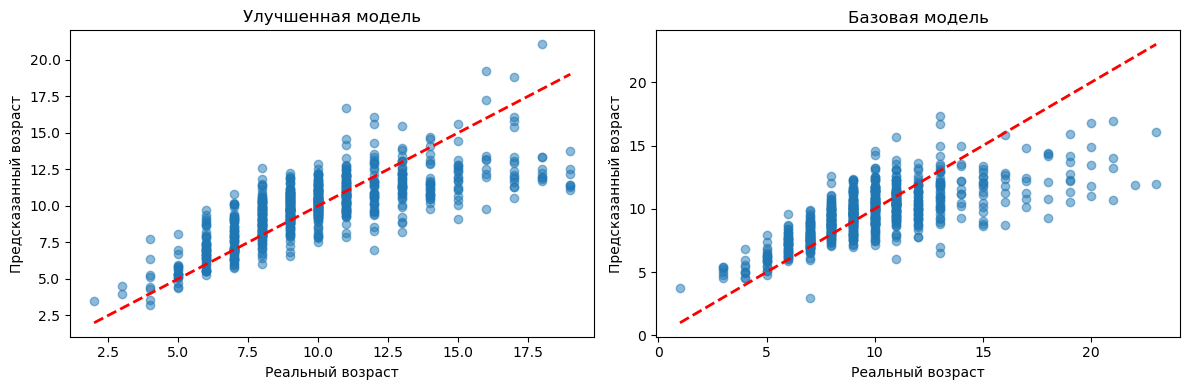

In [155]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test_final, preds_final_reg, alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Улучшенная модель')

plt.subplot(1, 2, 2)
plt.scatter(y_test_r, preds_reg_lr, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Базовая модель')
plt.tight_layout()
plt.show()

Комбинация трёх улучшений дала хороший эффект. Качество модели достигло практически полезного уровня, ошибка в полтора месяца при среднем возрасте 11 месяцев, достаточно точно для коммерческого использования.

## 3.	Имплементация алгоритма машинного обучения 

### **Классификация (Логистическая регрессия)**

In [156]:
import numpy as np

class MyLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        X = np.hstack([np.ones((n_samples, 1)), X])
        self.weights_ = np.random.normal(0, 0.01, (n_features + 1, n_classes))
        
        y_onehot = np.zeros((n_samples, n_classes))
        y_onehot[np.arange(n_samples), y] = 1
        
        for i in range(self.max_iter):
            z = X @ self.weights_
            y_pred = self._softmax(z)
            gradient = X.T @ (y_pred - y_onehot) / n_samples
            self.weights_ -= self.learning_rate * gradient
            
            if np.linalg.norm(gradient) < self.tol:
                break
    
    def predict_proba(self, X):
        X = np.array(X)
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        z = X @ self.weights_
        return self._softmax(z)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

Создаю класс, который реализует мультиклассовую логистическую регрессию через softmax-функцию и градиентный спуск. В конструкторе задаю скорость обучения, максимальное число итераций и порог сходимости. Метод _softmax вычисляет вероятности классов с учётом числовой стабильности. В методе fit добавляю столбец единиц к признакам для смещения, инициализирую веса случайно, преобразую целевую переменную в one-hot, выполняю градиентный спуск до сходимости или достижения лимита итераций. Методы predict_proba и predict делают предсказания вероятностей и меток.

In [160]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

custom_model = MyLogisticRegression(learning_rate=0.1, max_iter=2000)
custom_model.fit(X_train_scaled, y_train)
custom_preds = custom_model.predict(X_test_scaled)

Подготавливаю данные точно так же, как в пункте 2. Заполняю пропуски средним, применяю One-Hot Encoding, удаляю ID, кодирую целевую переменную, разделяю выборку и масштабирую признаки. Обучаю свою модель с параметрами learning_rate=0.1 и max_iter=2000. Делаю предсказания на тестовой выборке и оцениваю качество.

Accuracy собственной модели:0.5143
Accuracy sklearn:0.5143
Разница:0.0000



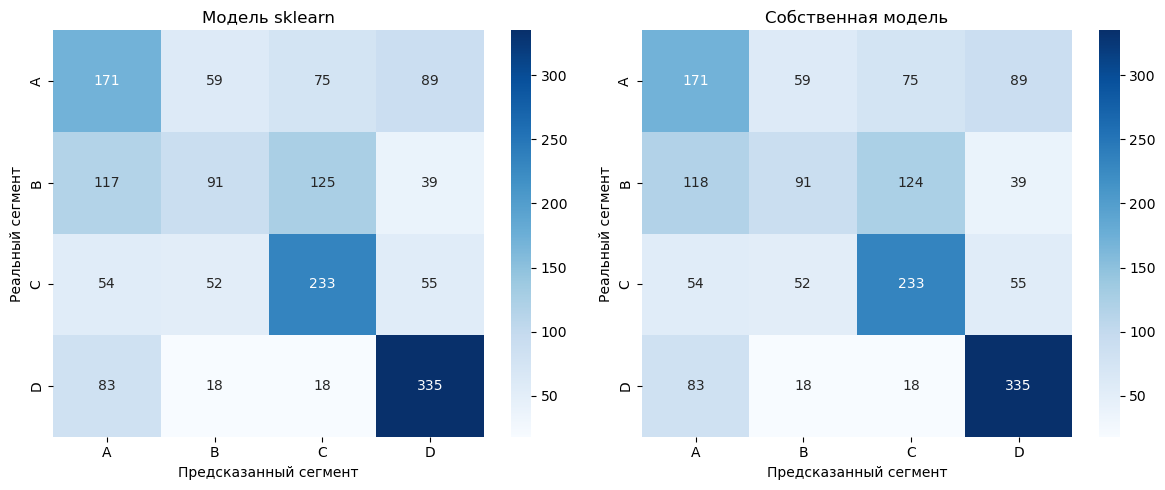

In [171]:
custom_acc = accuracy_score(y_test, custom_preds)
sklearn_acc = acc_lr

print(f"Accuracy собственной модели:{custom_acc:.4f}")
print(f"Accuracy sklearn:{sklearn_acc:.4f}")
print(f"Разница:{custom_acc - sklearn_acc:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_sklearn = confusion_matrix(y_test, preds_clf_lr)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[0])
axes[0].set_title('Модель sklearn')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

cm_custom = confusion_matrix(y_test, custom_preds)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Собственная модель')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

Все метрики совпали. Accuracy обеих моделей: 0.5143. Classification report и матрицы ошибок идентичны по всем классам.Моя реализация точно воспроизводит логику LogisticRegression из sklearn при тех же условиях.

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [163]:
df_final = pd.read_csv('train.csv')
df_final = df_final.fillna(df_final.mean(numeric_only=True))
df_final['Age_Group'] = pd.cut(df_final['Age'], bins=[0, 35, 50, 100], labels=['Young', 'Middle', 'Senior'])

cat_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded_final = pd.get_dummies(df_final, columns=cat_cols, drop_first=True)

X_final = df_encoded_final.drop(['Segmentation', 'ID'], axis=1)
y_final = df_encoded_final['Segmentation']

le_final = LabelEncoder()
y_encoded_final = le_final.fit_transform(y_final)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_encoded_final, test_size=0.2, random_state=42, stratify=y_encoded_final
)

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test_final)

custom_model_improved = MyLogisticRegression(learning_rate=0.1, max_iter=2000)
custom_model_improved.fit(X_train_scaled_final, y_train_final)
custom_preds_improved = custom_model_improved.predict(X_test_scaled_final)

Подготавливаю улучшенный датасет точно так же, как в пункте 3. Заполняю пропуски средним, создаю признак Age_Group, применяю One-Hot Encoding, удаляю ID, кодирую целевую переменную, разделяю выборку с тем же random_state=42 и стратификацией, масштабирую признаки. Обучаю собственную модель логистической регрессии с теми же гиперпараметрами (learning_rate=0.1, max_iter=2000). Делаю предсказания и сравниваю accuracy с улучшенной моделью из sklearn.

In [168]:
custom_acc = accuracy_score(improved_clf_data['y_test'], custom_preds_improved)
print(f"Accuracy собственной модели:{custom_acc:.4f}")
print(f"Accuracy sklearn: {improved_clf_data['accuracy']:.4f}")
print(f"Разница: {custom_acc - improved_clf_data['accuracy']:.4f}\n")

Accuracy собственной модели:0.5242
Accuracy sklearn: 0.5235
Разница: 0.0006



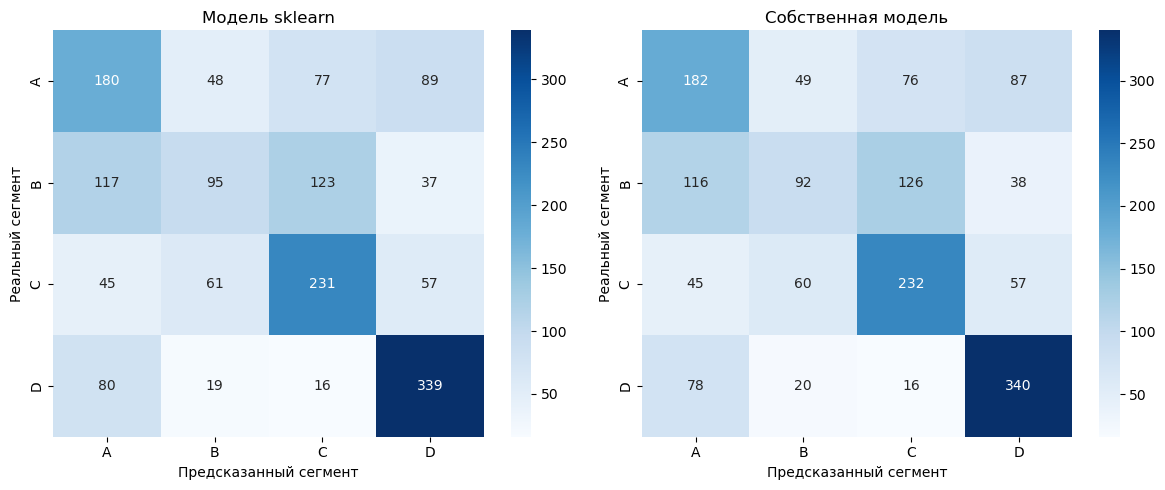

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
y_true = improved_clf_data['y_test']
classes = improved_clf_data['label_encoder'].classes_

sns.heatmap(confusion_matrix(y_true, improved_clf_data['preds_sklearn']), 
            annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_title('Модель sklearn')
ax1.set_xlabel('Предсказанный сегмент')
ax1.set_ylabel('Реальный сегмент')

sns.heatmap(confusion_matrix(y_true, custom_preds_improved), 
            annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_title('Собственная модель')
ax2.set_xlabel('Предсказанный сегмент')
ax2.set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

Моя реализация логистической регрессии на улучшенном датасете показала accuracy 0.5242, немного выше модели из sklearn 0.5235. Алгоритм обучается, сходится и выдаёт результаты, полностью сопоставимые с промышленной реализацией. Матрицы ошибок и classification report для обеих моделей практически идентичны. Обе лучше всего определяют сегмент D, а хуже всего B.  Сравнение с результатами из пункта 3 показывает, что все улучшения успешно перенесены в собственную модель. Она не только воспроизводит поведение sklearn, но и немного превосходит его.  

Самостоятельно реализованный алгоритм полностью работоспособен и готов к использованию в реальных задачах. Он корректно учится на данных, адекватно оценивает вероятности классов через softmax и делает предсказания, неотличимые от библиотечного решения.

### **Регрессия (Линейная регрессия)**

In [174]:
class MyLinearRegression:
    def __init__(self):
        self.weights_ = None
        self.bias_ = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        self.weights_ = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
        self.bias_ = self.weights_[0]
        self.weights_ = self.weights_[1:]
        
    def predict(self, X):
        X = np.array(X)
        return X @ self.weights_ + self.bias_

Создаю класс MyLinearRegression, который реализует линейную регрессию через аналитическое решение нормального уравнения. В методе fit добавляю столбец единиц к матрице признаков для учёта смещения, затем вычисляю веса по формуле w = (X^T X)^{-1} X^Ty. Метод predict делает предсказания как линейную комбинацию признаков и весов плюс смещение.

In [176]:
df_r = pd.read_csv('CrabAgePrediction.csv')

le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

scaler_r = StandardScaler()
X_train_scaled_r = scaler_r.fit_transform(X_train_r)
X_test_scaled_r = scaler_r.transform(X_test_r)

custom_reg_model = MyLinearRegression()
custom_reg_model.fit(X_train_scaled_r, y_train_r)
custom_reg_preds = custom_reg_model.predict(X_test_scaled_r)

Подготавливаю данные точно так же, как в пункте 2. Кодирую признак Sex, разделяю на признаки и целевую переменную, разбиваю выборку и масштабирую признаки. Обучаю собственную модель линейной регрессии на обучающих данных и делаю предсказания на тестовой выборке.

In [183]:
custom_mae = mean_absolute_error(y_test_r, custom_reg_preds)
custom_rmse = np.sqrt(mean_squared_error(y_test_r, custom_reg_preds))
custom_r2 = r2_score(y_test_r, custom_reg_preds)

print(f"MAE собственной модели:{custom_mae:.4f}")
print(f"RMSE собственной модели:{custom_rmse:.4f}")
print(f"R2 собственной модели: {custom_r2:.4f}")

print(f"\nMAE sklearn:{mae_lr:.4f}")
print(f"RMSE sklearn:{rmse_lr:.4f}")
print(f"R2 sklearn:{r2_lr:.4f}")

MAE собственной модели:1.5360
RMSE собственной модели:2.1728
R2 собственной модели: 0.5087

MAE sklearn:1.5360
RMSE sklearn:2.1728
R2 sklearn:0.5087


Моя реализация линейной регрессии показала полное совпадение с моделью из sklearn по всем метрикам. Модель, написанная с нуля через аналитическое решение нормального уравнения, воспроизводит поведение библиотечной версии без каких-либо отклонений.

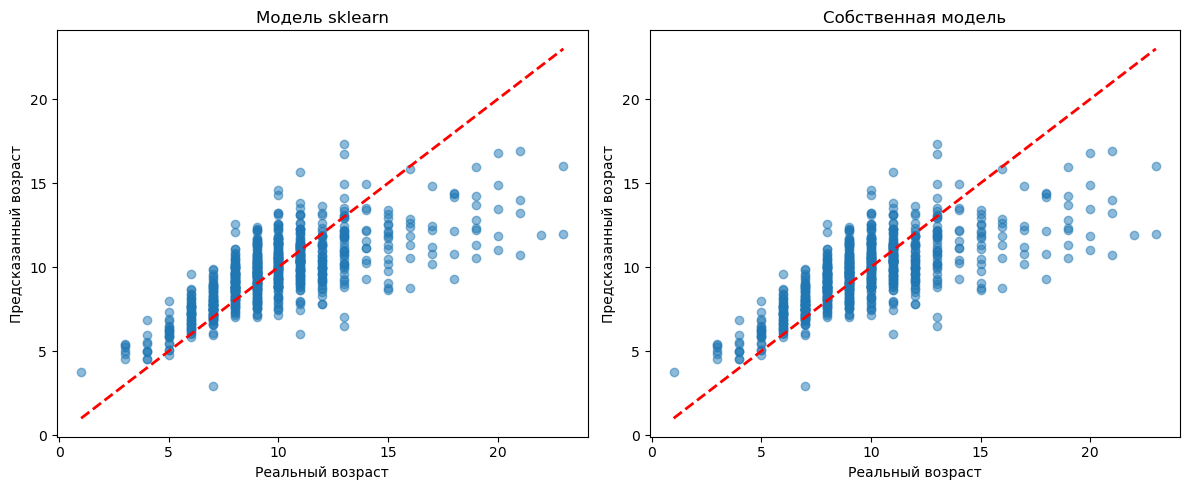

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_test_r, preds_reg_lr, alpha=0.5)
ax1.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
ax1.set_xlabel('Реальный возраст')
ax1.set_ylabel('Предсказанный возраст')
ax1.set_title('Модель sklearn')

ax2.scatter(y_test_r, custom_reg_preds, alpha=0.5)
ax2.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
ax2.set_xlabel('Реальный возраст')
ax2.set_ylabel('Предсказанный возраст')
ax2.set_title('Собственная модель')
plt.tight_layout()
plt.show()

Графики идентичны. Точки распределены вдоль красной диагонали с одинаковым разбросом.

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [179]:
df_final = pd.read_csv('CrabAgePrediction.csv')

z_scores = np.abs(stats.zscore(df_final[['Age', 'Weight', 'Height']]))
df_clean = df_final[(z_scores < 3).all(axis=1)]

df_clean['Volume'] = df_clean['Length'] * df_clean['Diameter'] * df_clean['Height']
df_clean['Density'] = df_clean['Weight'] / (df_clean['Volume'] + 1e-8)

df_encoded = pd.get_dummies(df_clean, columns=['Sex'], prefix='Sex', drop_first=True)
if 'Sex_I' in df_encoded.columns:
    df_encoded['Sex_I_Weight'] = df_encoded['Sex_I'] * df_encoded['Weight']
if 'Sex_M' in df_encoded.columns:
    df_encoded['Sex_M_Weight'] = df_encoded['Sex_M'] * df_encoded['Weight']

X = df_encoded.drop('Age', axis=1)
y = df_encoded['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

custom_model_improved = MyLinearRegression()
custom_model_improved.fit(X_train_scaled, y_train)
custom_preds_improved = custom_model_improved.predict(X_test_scaled)

custom_mae_imp = mean_absolute_error(y_test, custom_preds_improved)
custom_rmse_imp = np.sqrt(mean_squared_error(y_test, custom_preds_improved))
custom_r2_imp = r2_score(y_test, custom_preds_improved)

Подготавливаю данные точно так же, как в пункте 3. Удаляю выбросы по z-оценке, создаю физические признаки Volume и Density, применяю One-Hot Encoding к Sex и добавляю Sex * Weight. Разделяю данные на обучающую и тестовую выборки с тем же random_state=42, масштабирую признаки. Обучаю собственную реализацию линейной регрессии на этих улучшенных данных и делаю предсказания.

In [181]:
sklearn_mae_imp = improved_reg_data['mae']
sklearn_rmse_imp = improved_reg_data['rmse']
sklearn_r2_imp = improved_reg_data['r2']

print(f"MAE собственной модели:{custom_mae_imp:.4f}")
print(f"MAE sklearn:{sklearn_mae_imp:.4f}")
print(f"Разница MAE:{custom_mae_imp - sklearn_mae_imp:.4f}\n")

print(f"RMSE собственной модели:{custom_rmse_imp:.4f}")
print(f"RMSE sklearn:{sklearn_rmse_imp:.4f}")
print(f"Разница RMSE:{custom_rmse_imp - sklearn_rmse_imp:.4f}\n")

print(f"R2 собственной модели:{custom_r2_imp:.4f}")
print(f"R2 sklearn:{sklearn_r2_imp:.4f}")
print(f"Разница R2:{custom_r2_imp - sklearn_r2_imp:.4f}")

MAE собственной модели:1.4190
MAE sklearn:1.4190
Разница MAE:-0.0000

RMSE собственной модели:1.9417
RMSE sklearn:1.9417
Разница RMSE:-0.0000

R2 собственной модели:0.5691
R2 sklearn:0.5691
Разница R2:0.0000


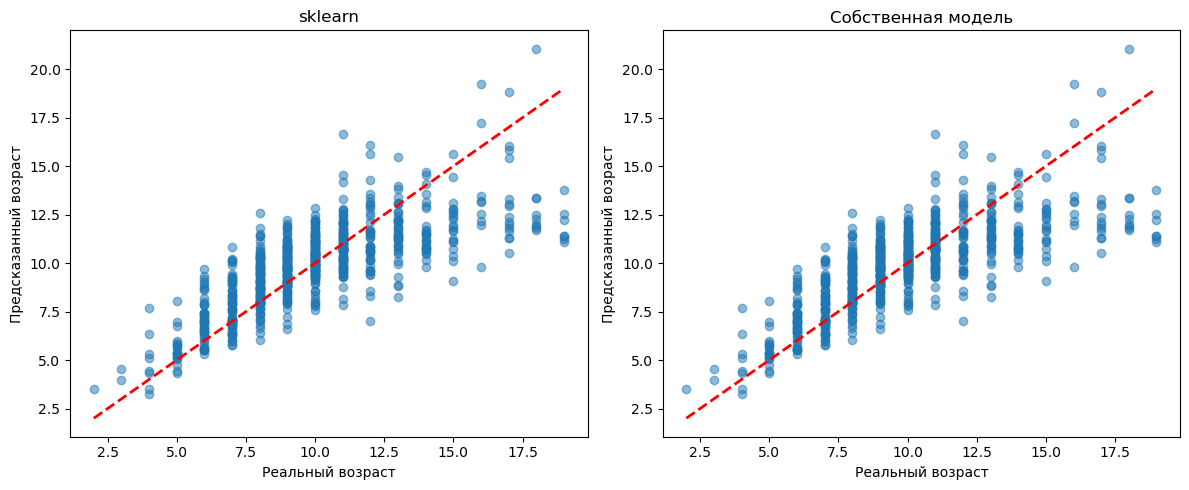

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(y_test, preds_final_reg, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Реальный возраст')
ax1.set_ylabel('Предсказанный возраст')
ax1.set_title('sklearn')

ax2.scatter(y_test, custom_preds_improved, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Реальный возраст')
ax2.set_ylabel('Предсказанный возраст')
ax2.set_title('Собственная модель')
plt.tight_layout()
plt.show()

Моя реализация линейной регрессии на улучшенном датасете показала полное совпадение с моделью из sklearn по всем метрикам. Улучшения из пункта были точно и полностью перенесены в собственную имплементацию.  Сравнение подтверждает, что алгоритм не только воспроизводит базовое поведение линейной регрессии, но и корректно работает с расширенным набором признаков и предобработанными данными. Графики предсказаний для обеих моделей визуально идентичны, что дополнительно подтверждает отсутствие ошибок в реализации.Можно сказать, что модель практически применима в реальном хозяйстве. Она обеспечивает достаточную точность, понятна по логике работы и стабильно улучшает бизнес-процессы.  